In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys
sys.path.insert(0, "/home/quadry/binary_planet_host_project")
import kepler
import astropy.units as u
import astropy.constants as c
from scipy import (special, stats)
from functions import  single_probability, simulate
import matplotlib.tri as tri
G =c.G.to(u.au ** 3 / u.M_sun / u.day ** 2).value
observing_span = 668

In [2]:
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.family'] = "serif"
plt.rcParams["errorbar.capsize"] = 20



params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}


plt.rcParams['mathtext.fontset'] = 'dejavuserif'

plt.rcParams.update(params)
plt.rc('font',**{'family':'serif','sans-serif':['Times']})

plt.rcParams['font.family'] = "serif"

In [3]:
proc_kic = pd.read_csv('/home/quadry/binary_planet_host_project/data/bright_kic_data-xm-rc.0.csv')


In [4]:
proc_kic = proc_kic [proc_kic ['radial_velocity_error'].notna()]
m_g = proc_kic['phot_rp_mean_mag']
proc_kic['converted_sigma_1'] = np.sqrt((2*proc_kic['radial_velocity_error']**2*proc_kic['rv_nb_transits']-0.0242*proc_kic['rv_nb_transits'])/np.pi)
proc_kic['color bins'] = pd.cut(proc_kic['bp_rp'], 10)
proc_kic['mag bins'] = pd.cut(proc_kic['phot_rp_mean_mag'], 10)

proc_kic['color label'] = pd.cut(proc_kic['bp_rp'], 10, labels=False)
proc_kic['mag label'] = pd.cut(proc_kic['phot_rp_mean_mag'], 10, labels=False)

In [6]:
p = proc_kic[proc_kic['rv_p_single']>.9].dropna().groupby(['color bins', 'mag bins']).agg('mean')[['converted_sigma_1','radial_velocity_error'
                                                                                        ,"rv_gp_predict_theta",
                                                              "rv_gp_predict_mu_single","rv_gp_predict_sigma_single","rv_gp_predict_sigma_multiple",'color label','mag label']]
p.unstack()
p = p.dropna()
p = p.reset_index(level=['color bins', 'mag bins'])
colors = []
for i in range(len(p)):
    colors.append(p['color bins'].loc[i].mid)
p['colors'] = colors

mags = []
for i in range(len(p)):
    mags.append(p['mag bins'].loc[i].mid)
p['mags'] = mags

In [7]:
N = 5000000
bin_info = p.sample(n=N, replace=True)

maxn = 10
number_of_obs = np.random.randint(7, maxn, size=N)
mask = np.arange(maxn)[None, :] < number_of_obs[:, None]

t = np.random.uniform(0, observing_span, (N, maxn))
m_1 = np.random.uniform(low=1, high=2.5, size=N)
q = np.zeros(N)
#m_2 = np.random.uniform(low=0.2, high=1, size=N)
e = np.random.random_sample(size=N)
i = np.random.uniform(low=0, high=90, size=N)
a = 10**np.random.uniform(low=-2, high=2, size=N)
phi = np.random.uniform(0,2*np.pi, size=N)
w = np.random.uniform(0,2*np.pi, size=N)

bin_info = p.sample(n=N, replace=True)
sigma = bin_info['converted_sigma_1'][:,None]

r = simulate.RadialVelocity(m_1[:, None], q[:, None], e[:, None], i[:, None], a[:, None], phi[:, None], w[:, None], t, sigma)[0]
r[~mask] = 0.0
norm = 1 / np.sum(mask, axis=1)
mu = np.sum(r, axis=1) * norm
np.subtract(r, mu[:, None], out=r)
np.square(r, out=r)
r[~mask] = 0.0
np.sum(r, axis=1, out=mu)
np.multiply(mu, norm, out=mu)
std = np.sqrt(mu, out=mu)

single_data = pd.DataFrame()
single_data['m1']=m_1
single_data['q']=q
single_data['e']=e
single_data['i']=i
single_data['a']=a
single_data['t']=np.nan
single_data['t']=number_of_obs
single_data['phi']=phi
single_data['w']=w

single_data['RV'] = np.mean(r, axis=1)
single_data['RV jitter'] = std

singles = pd.concat((single_data,bin_info.reset_index()),axis=1)

<ipython-input-7-d1827555f149>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sigma = bin_info['converted_sigma_1'][:,None]


In [8]:

N = 1000000
bin_info = p.sample(n=N, replace=True)

maxn = 10
number_of_obs = np.random.randint(7, maxn, size=N)
mask = np.arange(maxn)[None, :] < number_of_obs[:, None]

t = np.random.uniform(0, observing_span, (N, maxn))
m_1 = np.random.uniform(low=1, high=2.5, size=N)
q = 10**np.random.uniform(low=-2, high=0, size=N)
#m_2 = np.random.uniform(low=0.2, high=1, size=N)
e = np.random.random_sample(size=N)
i = np.random.uniform(low=0, high=90, size=N)
a = 10**np.random.uniform(low=-2, high=2, size=N)
phi = np.random.uniform(0,2*np.pi, size=N)
w = np.random.uniform(0,2*np.pi, size=N)

bin_info = p.sample(n=N, replace=True)
sigma = bin_info['converted_sigma_1'][:,None]
rv, k = simulate.RadialVelocity(m_1[:, None], q[:, None], e[:, None], i[:, None], a[:, None], phi[:, None], w[:, None], t, sigma)
RV=rv

rv[~mask] = 0.0
norm = 1 / np.sum(mask, axis=1)
mu = np.sum(rv, axis=1) * norm
np.subtract(rv, mu[:, None], out=rv)
np.square(rv, out=rv)
rv[~mask] = 0.0
np.sum(rv, axis=1, out=mu)
np.multiply(mu, norm, out=mu)
std = np.sqrt(mu, out=mu)

binary_data = pd.DataFrame()
binary_data['m1']=m_1
binary_data['q']=q
binary_data['e']=e
binary_data['i']=i
binary_data['a']=a
binary_data['t']=np.nan
binary_data['t']=number_of_obs
binary_data['phi']=phi
binary_data['w']=w

binary_data['RV'] = np.mean(RV, axis=1)
binary_data['RV jitter'] = std
binaries = pd.concat((binary_data,bin_info.reset_index()),axis=1)

<ipython-input-8-94af4d8478ae>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sigma = bin_info['converted_sigma_1'][:,None]


In [9]:
p_theta, p_mu_single, p_sigma_single, p_sigma_multiple,color,mag = singles[["rv_gp_predict_theta","rv_gp_predict_mu_single",
                                                            "rv_gp_predict_sigma_single","rv_gp_predict_sigma_multiple",'color label','mag label']][:N].values.T

y =single_probability.get_j_rv(singles)[:N]

single_p = (single_probability.calculate_rv_p_single(p_theta, p_mu_single, p_sigma_single, p_sigma_multiple, y))

singles['rv_p'] = np.nan

singles['rv_p'][:N]=single_p

/home/quadry/binary_planet_host_project/functions/single_probability.py:9: RuntimeWarning: invalid value encountered in sqrt
  jv.append(np.sqrt((2/np.pi) * dataframe["t"].iloc[i] * (dataframe["RV jitter"].iloc[i]**2 - 0.11**2)))
<ipython-input-9-6336f44c53ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles['rv_p'][:N]=single_p
/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
p_theta, p_mu_single, p_sigma_single, p_sigma_multiple,color,mag = binaries[["rv_gp_predict_theta","rv_gp_predict_mu_single",
                                                            "rv_gp_predict_sigma_single","rv_gp_predict_sigma_multiple",'color label','mag label']][:N].values.T

y =single_probability.get_j_rv(binaries)[:N]


binary_p = (single_probability.calculate_rv_p_single(p_theta, p_mu_single, p_sigma_single, p_sigma_multiple, y))

binaries['rv_p'] = np.nan

binaries['rv_p'][:N]=binary_p

<ipython-input-10-b94809caac5b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binaries['rv_p'][:N]=binary_p


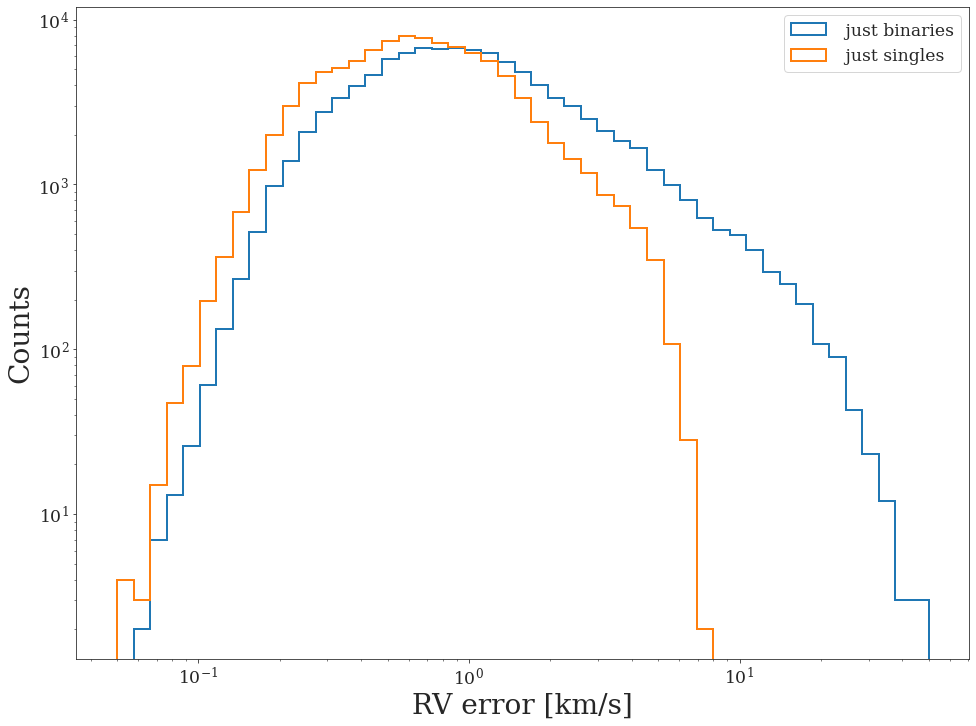

In [13]:

plt.hist(binaries['RV jitter'].sample(n=100000),  bins = np.geomspace(.05, 50, 50), label=' just binaries', histtype='step', lw=2)
plt.hist(singles['RV jitter'].sample(n=100000),  bins = np.geomspace(.05, 50, 50), label=' just singles', histtype='step', lw=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('RV error [km/s]',fontsize=28)
plt.ylabel('Counts',fontsize=28)
plt.legend()
plt.savefig('rv_jitter_dist.png', bbox_inches='tight')